In [2]:
from mongo import MongoDBManager
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import re

# Retrieving data

In [3]:
load_dotenv()
uri = os.getenv('MONGODB_URI')
database_name = os.getenv('DATABASE_NAME')
mongo_manager = MongoDBManager(uri, database_name)

In [5]:
documents = mongo_manager.read_all_documents_in_collection_with_GridFS()

Erreur lors de la lecture du document ID 66d69aa0604efd403dc468a4: Unterminated string starting at: line 1 column 67362139 (char 67362138)
Erreur lors de la lecture du document ID 66d69bc0943cfa0276f23ca1: Unterminated string starting at: line 1 column 235788581 (char 235788580)


# Formating Datas

In [6]:
data_formated = []
for country in documents.keys():
   for profession in documents[country].keys():
       for language in documents[country][profession].keys():
            for data in documents[country][profession][language]:
                data['country'] = country
                data['profession'] = profession
                data['language'] = language
                data_formated.append(data)
               
len(data_formated)

30588

# Visualizing Data

In [7]:
df = pd.DataFrame(data_formated)
df.describe()

,positionTitle,companyName,location,jobType,description,datePosted,salary,shiftAndSchedule,jobBenefits,country,profession,language,updatedDate
count,30588,30588,30588,30588,30588,29778,30588,30588,30588,30588,30588,30588,19437
unique,7687,3664,3301,1602,5382,48,1330,168,1660,1,17,2,5
top,Operations Manager,Amazon.com Services LLC,Remote,"[time, Full-time]",Job Title: AI/Big Data/Autonomous Drive Expert...,2024-07-26,Full,,[],Canada,Experte ou expert en science des données (data...,en,2024-08-25
freq,508,284,1262,8970,148,3716,10028,26548,12131,30588,7481,30356,8974


In [ ]:
df = df.applymap(lambda x: tuple(x) if isinstance(x, list) else x)
df = df.drop_duplicates()
df = df[((df['positionTitle'] != '') & (df['description'] != '')) | df['positionTitle'] != '']
df['jobType'] = df.apply(
    lambda x: tuple(list(x['jobType']) + list(x['salary'])) 
    if not re.search(r'\d+', str(x['salary'])) 
    else x['jobType'], 
    axis=1
)
df['salary'] = df['salary'].map(
    lambda x: '' 
    if not re.search(r'\d+', str(x))
    else x
)

df['salary'] = df.apply(
    lambda x: str(x['salary']+"-"+str(list(x['jobType'])[0]) )
    if not re.search(r'\d+', str(list(x['jobType'])[0])) 
    else str(x['salary']), 
    axis=1
)
df['jobType'] = df['jobType'].map(
    lambda x: '' 
    if not re.search(r'\d+', str(x))
    else x
)

df.describe()

C:\Users\gueid\AppData\Local\Temp\ipykernel_29680\3461638273.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: tuple(x) if isinstance(x, list) else x)


,positionTitle,companyName,location,jobType,description,datePosted,salary,shiftAndSchedule,jobBenefits,country,profession,language,updatedDate
count,29479,29479,29479,29479,29479,28421,29479,29479,29479,29479,29479,29479,7018
unique,12685,5664,4107,1567,9532,41,2103,224,2491,3,11,2,2
top,Financial Analyst,Scotiabank,"Toronto, ON","(Temps plein,)",,2024-07-22,,,(),Canada,Analyste de marché,en,2024-08-25
freq,225,261,1556,6290,54,4082,14851,26334,14600,15953,7634,23668,5166


<Axes: xlabel='location'>

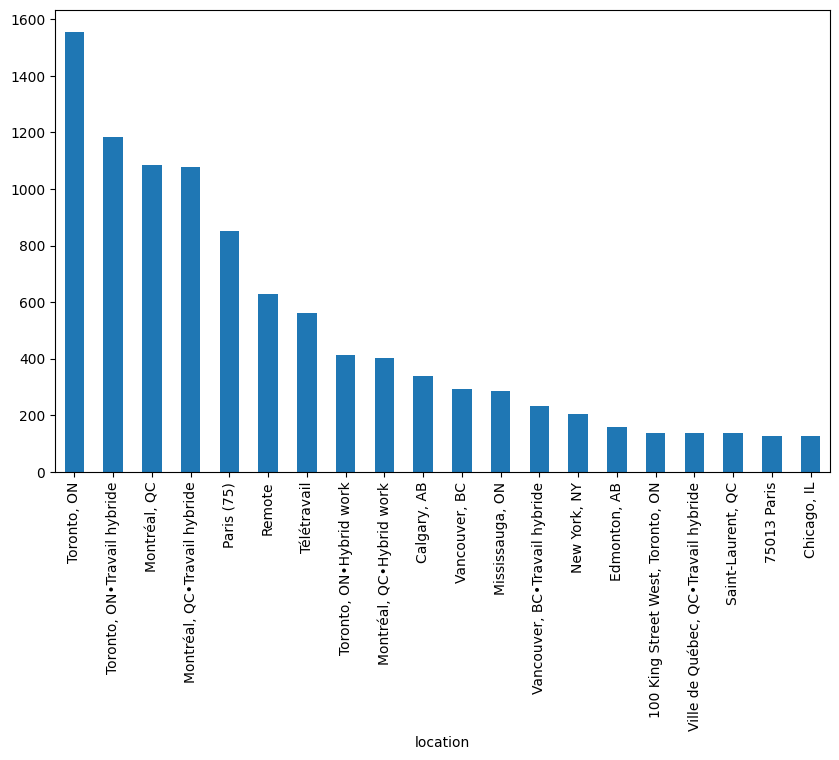

In [ ]:
plt.figure(figsize=(10, 6))
df['location'].value_counts()[:20].plot(kind='bar')

<Axes: xlabel='jobType,salary'>

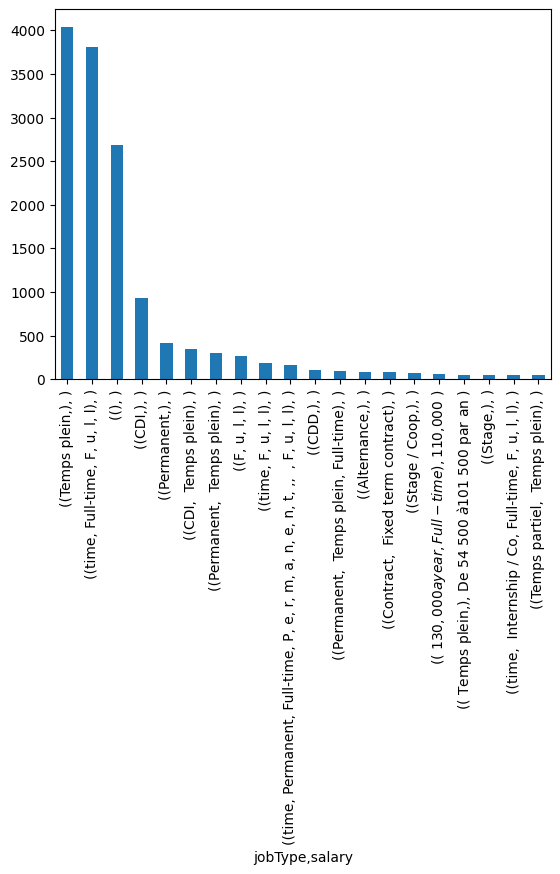

In [ ]:
df_counts = df[['jobType','salary']].value_counts()[:20].plot(kind='bar')
# df_counts.plot(kind='scatter', x='positionTitle', y='location', s=df_counts['count'] * 10)
# plt.xticks(rotation=45)
# plt.show()
df_counts

<Axes: xlabel='salary'>

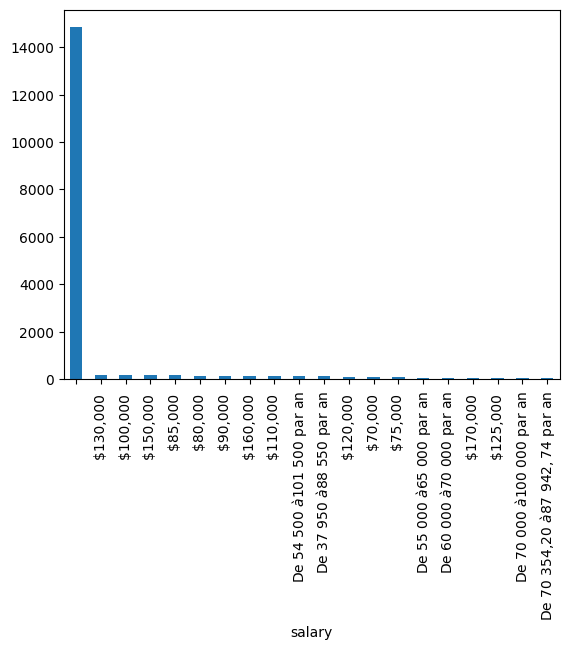

In [ ]:
df['salary'] = df.apply(
    lambda x: "" 
    if not re.search(r'\d+', str(x['salary'])) 
    else x['salary'], 
    axis=1
)

# Afficher les 10 valeurs les plus fréquentes dans salary
df['salary'].value_counts()[:20].plot(kind='bar')

In [ ]:
df_value_count=df[['positionTitle','companyName','location','description',"datePosted"]]
df_value_count

,positionTitle,companyName,location,description,datePosted
0,,,,,
1,"Regional Vice President of Sales, North America",NetAlly,Remote,DUTIES & RESPONSIBILITIES\n\nNetAlly is seekin...,2024-08-05
2,"Revenue Operations Manager, Partner Ops","Guideline, Inc.",Remote,Guideline is looking for a Revenue Operations ...,2024-08-08
3,Revenue Operations Manager,Liatrio,Remote,About Liatrio\nLiatrio is a boutique consultin...,2024-08-07
4,Revenue Operations Manager (Remote),Liatrio,Remote,About Liatrio\nLiatrio is a boutique consultin...,2024-08-07
...,...,...,...,...,...
49767,Service Technician,"Amazon Canada Fulfillment Services, ULC - B85","Toronto, ON",Currently enrolled in a bachelor’s degree prog...,2024-08-23
49768,Commercial Services Operations Manager - Tsaww...,"Amazon Canada Fulfillment Services, ULC - B85","Toronto, ON",Currently enrolled in a bachelor’s degree prog...,2024-08-20
49769,Material Coordinator,"Amazon Canada Fulfillment Services, ULC - B85","Toronto, ON",Currently enrolled in a bachelor’s degree prog...,2024-08-23
49770,Shipping Manager,"Amazon Canada Fulfillment Services, ULC - B85","Toronto, ON",Currently enrolled in a bachelor’s degree prog...,2024-08-23
